In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [57]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

def draw_graph(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        # if n._op:
        #     dot.node(name=str(id(n)) + n._op, label=n._op)
        #     dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [37]:
class Value():
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        self.label = label
        self.grad = 0.0
        self.topo = []
        
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            # set the gradient of each child node
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __radd__(self, other):
        return self + other
    
    def __truediv__(self, other):
        return self * (other**-1)
    
    def __rtruediv__(self, other):
        return self.__truediv__(other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - (t**2)) * out.grad
            
        out._backward = _backward
        
        return out
    
    def __repr__(self):
        return f'Value({self.label}|data={self.data})'
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.topo = topo
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    def zero_grad(self):
        for node in reversed(self.topo):
            node.grad = 0.0
            
a = Value(2.0)
a * 2
2 * a
a + 2
2 + a
a / 2
2 / a

Value(|data=1.0)

In [249]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

In [250]:
d._prev

{Value(c|data=10.0), Value(e|data=-6.0)}

In [251]:
d._op

'+'

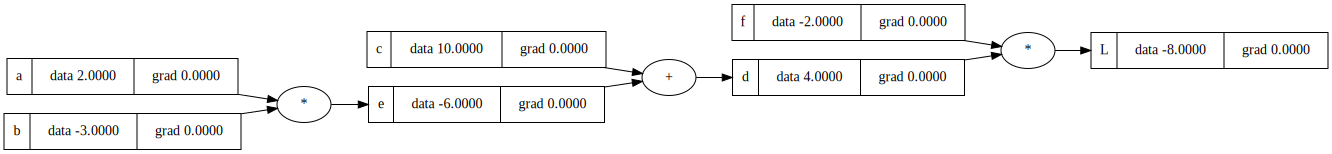

In [252]:
draw_dot(L)

In [253]:
L.grad = 1.0

In [254]:
# we can prove that dL/dL = 1 numerically by adjusting L by some h and calculating its slope (derivative)
def lol():
    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data # x1
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data + h # x2 (x1 + h)
    
    print('     L2    - L1 = ', (L2 - L1))
    print('  (L1 + h) - L1 = ', (L2 - L1))
    print('  (L1 - L1) + h = ', (L2 - L1))
    print('              h = ', h)
    print('          h / h = ', (L2-L1)/h)

lol()

     L2    - L1 =  0.001000000000000334
  (L1 + h) - L1 =  0.001000000000000334
  (L1 - L1) + h =  0.001000000000000334
              h =  0.001
          h / h =  1.000000000000334


In [ ]:
L = d * f

dL/dd = f

# numerical proof for dL/dd
((d+h * f) - (d*f)) / h
(d*f + h*f - d*f) / h
(d*f - d*f + f*h) / h
(f*h) / h
f
# so by adjusting d, L changes by f

# numerical proof for dL/df
((d* f+h) - (d*f)) / h
(d*f + d*h - d*f) / h
(d*f - d*f + d*h) / h
(d*h) / h
d
# so by adjusting f, L changes by d


In [256]:
d.grad = -2.0
f.grad = 4.0

In [257]:
def lol():
    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data # x1
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0 + h , label='f') # so by adjusting f, we should except the slope to be d (4.0)
    L = d * f; L.label = 'L'
    L2 = L.data # x2 (x1 + h)
    
    print('f = Value(-2.0 + h , label='f') # so by adjusting f, we should except the slope to be d (4.0)')
    print(' L2          - L1   = ', (L2 - L1))
    print(' d*(f+h)     - d*f  = ', (L2 - L1))
    print(' (d*f + d*h) - d*f  = ', (L2 - L1))
    print(' d*h                = ', (d.data*h))
    print(' d*h / h            = ', d.data*h/h)
    print(d)

lol()

f = Value(-2.0 + h , label=) # so by adjusting f, we should except the slope to be d (4.0)
 L2          - L1   =  0.0039999999999995595
 d*(f+h)     - d*f  =  0.0039999999999995595
 (d*f + d*h) - d*f  =  0.0039999999999995595
 d*h                =  0.004
 d*h / h            =  4.0
Value(d|data=4.0)


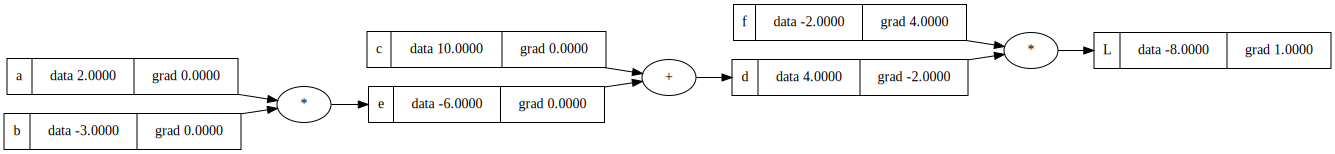

In [258]:
draw_dot(L)

In [259]:
# dL/dc = dL/dd * dd/dc

# d = c + e
# dd/dc = (d/dc)*c + (d/dc)*e
# dd/dc = 1 + 0 = 1

# dL/dc = dL/dd * dd/dc
#       = d.grad * 1
    
c.grad = -2.0 # dL/dc
e.grad = -2.0 # dL/de
    
# parents global gradient to L * local gradient to parent
    
# dL/db = dL/de * de/db
#       = -2.0  * ?

# e = a * b
# de/db = a
# de/da = b

# dL / da = (dL/de) * (de/da)
# dL / da = -2.0 * -3.0
# dL / db = -2.0 * 2.0
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

In [260]:
def lol():
    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data # x1
    
    a = Value(2.0, label='a')
    b = Value(-3.0 + h, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0 , label='f') # so by adjusting f, we should except the slope to be d (4.0)
    L = d * f; L.label = 'L'
    L2 = L.data # x2 (x1 + h)
    
    print((L2-L1)/h)
    
lol()

-3.9999999999995595


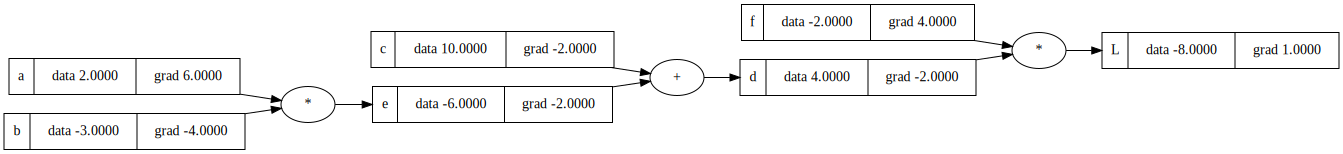

In [261]:
draw_dot(L)

In [262]:
# nudge our inputs (in the direction of their slopes) to try and make L go up - (optimization)
# only the leaf nodes, as those are the ones we usually have control over
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b;
d = e + c;
L = d * f;

print(L.data)




-7.286496


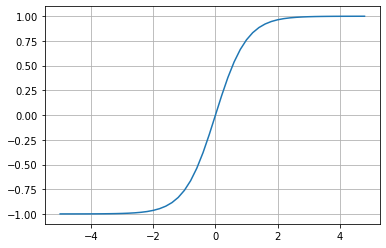

In [263]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [300]:
# Exercise: create a neuron with 2 inputs, 2 weights, 1 bais, and 1 tanh function

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.88137, label='b')
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

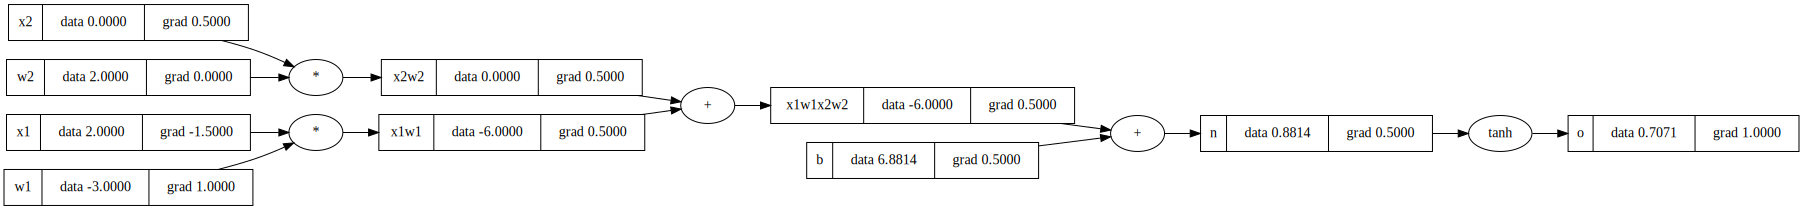

In [297]:
draw_dot(o)

In [286]:
o.grad = 1.0

In [298]:
# o = tanh(n)
# do/dn = 1 - tanh(n)**2
#       = 1 - o**2
n.grad = 1 - o.data**2
x1w1x2w2.grad = n.grad
b.grad = n.grad
x2w2.grad = x1w1x2w2.grad
x1w1.grad = x1w1x2w2.grad

x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data

w2.data += 1.0 # this should have no effect on the final output, since grad is 0 (i.e. x2 data is 0)

In [315]:
# calculate gradients using backward()

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.88137, label='b')
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

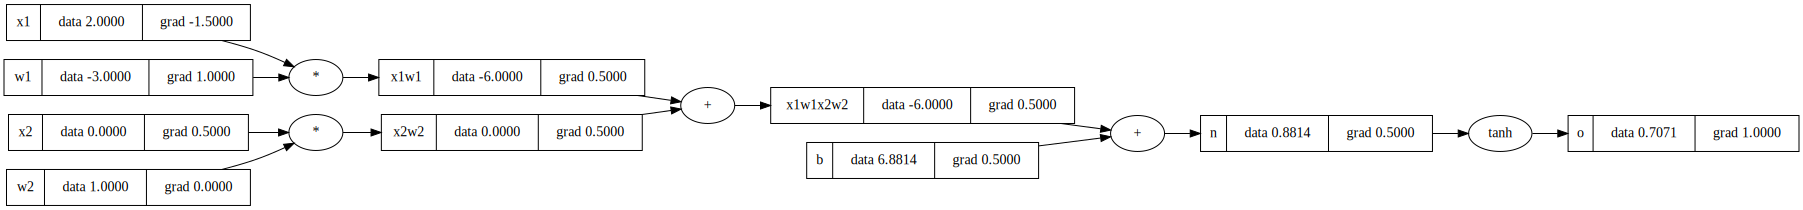

In [324]:
draw_dot(o)

In [323]:
o.grad = 1.0
o._backward()
n._backward()

x1w1x2w2._backward()
b._backward()

x1w1._backward()
x2w2._backward()

# niceeee

In [325]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child) # gaurentees children are inserted into topo[] before parent
        topo.append(v)
build_topo(o)
topo

[Value(x2|data=0.0),
 Value(w2|data=1.0),
 Value(x2w2|data=0.0),
 Value(x1|data=2.0),
 Value(w1|data=-3.0),
 Value(x1w1|data=-6.0),
 Value(x1w1x2w2|data=-6.0),
 Value(b|data=6.88137),
 Value(n|data=0.8813700000000004),
 Value(o|data=0.7071049876722272)]

In [326]:
for node in reversed(topo):
    node._backward()

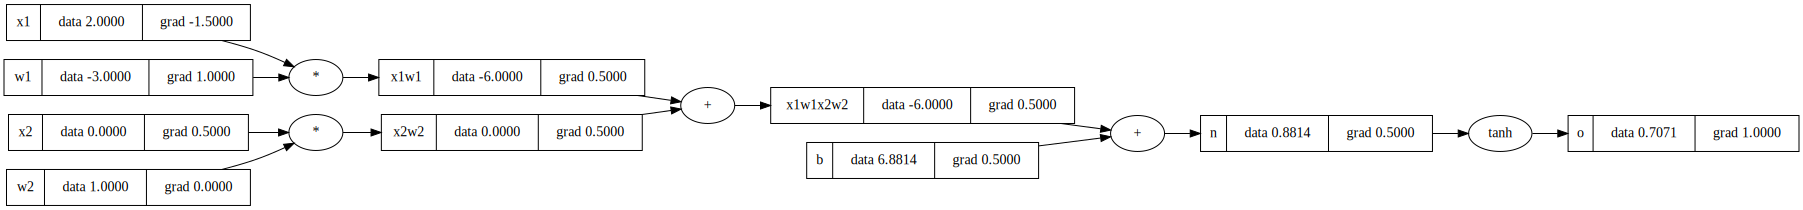

In [327]:
draw_dot(o)

In [331]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.88137, label='b')
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

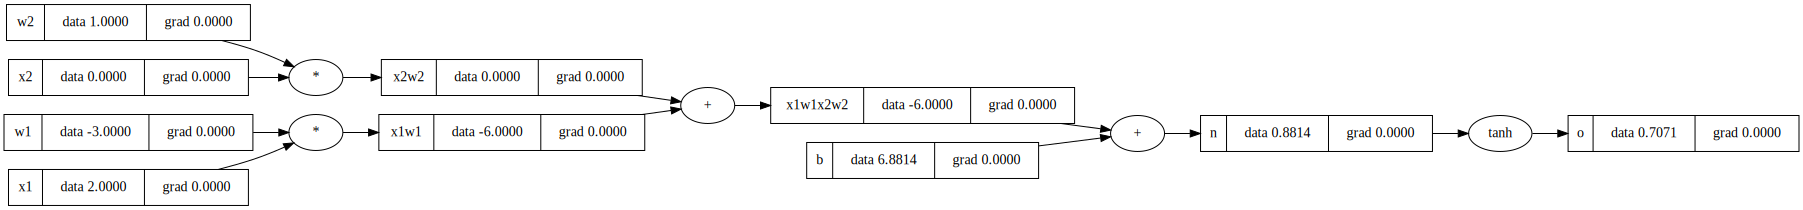

In [332]:
draw_dot(o)

In [333]:
o.backward()

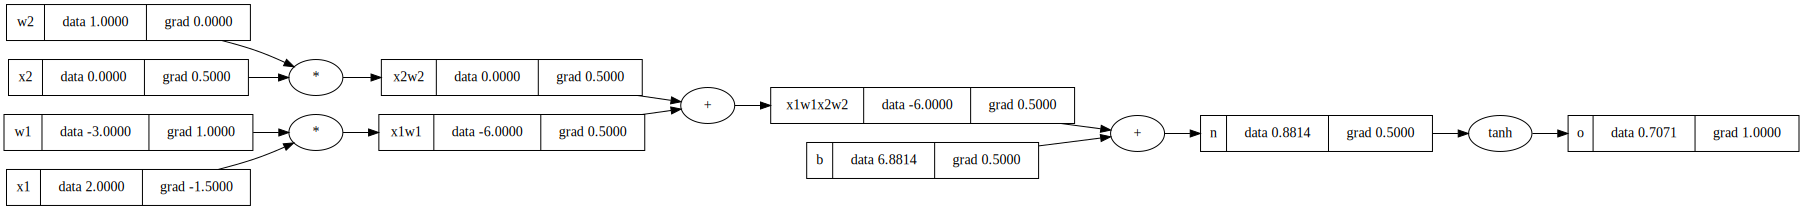

In [334]:
draw_dot(o)

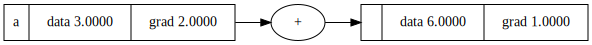

In [344]:
a = Value(3.0, label='a')
b = a + a # have a problem in __add__._backward() function of value. self.grad must accumulate (+=), otherwise the second reference to the same object a (other), will overwrite
b.backward()
draw_dot(b)

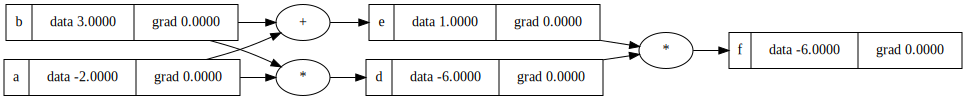

In [347]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b  ; d.label='d'
e = a + b  ; e.label='e'
f = d * e  ; f.label='f'
draw_dot(f)

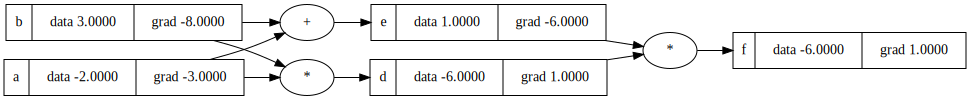

In [348]:
f.backward()
draw_dot(f)

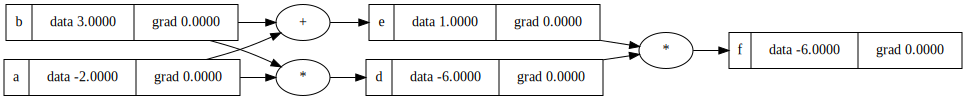

In [349]:
f.zero_grad()
draw_dot(f)

In [350]:
import torch

In [393]:
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.88137]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o)
print(o.data)
print(o.data.item())
o.backward()

print('---')
print('x1', x1.grad.item())
print('x2', x2.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)
tensor([0.7071], dtype=torch.float64)
0.7071050214706146
---
x1 -1.500007465833125
x2 0.5000024886110417
w1 1.0000049772220834
w2 0.0


In [60]:
import random
class Neuron:
    def __init__(self, nin, layer_num=None, neuron_num=None):
        self.w = [Value(random.uniform(-1,1), label=f'w{layer_num},{i},{neuron_num}') for i in range(nin)]
        self.b = Value(random.uniform(-1,1), label='b')
        
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)))
        act2 = act + self.b
        out = act2.tanh()
        return out
    

class Layer:
    def __init__(self, nin, nout, layer_num=None):
        self.nin = nin
        self.nout = nout
        
        self.neurons = [Neuron(self.nin, layer_num=layer_num, neuron_num=i) for i in range(self.nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts # [3] + [3, 4, 3] = [3, 3, 4, 3]
        self.layers = [Layer(sz[i], sz[i+1], layer_num=i) for i in range(len(nouts))]
                
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x) # override previous x with neuron outputs
        return x # return the last layer, to calculate the loss
        


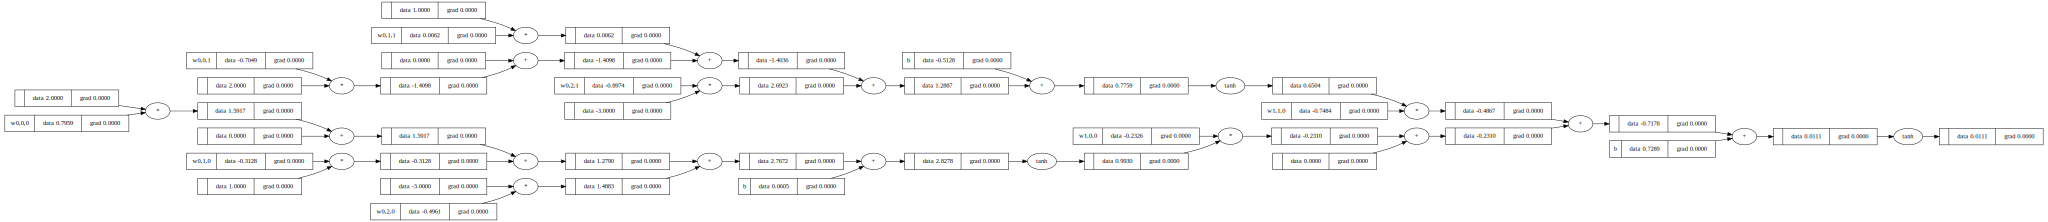

In [61]:
x = [2.0, 1.0, -3.0]
n = MLP(3, [2, 1])
out = n(x)
draw_dot(out)

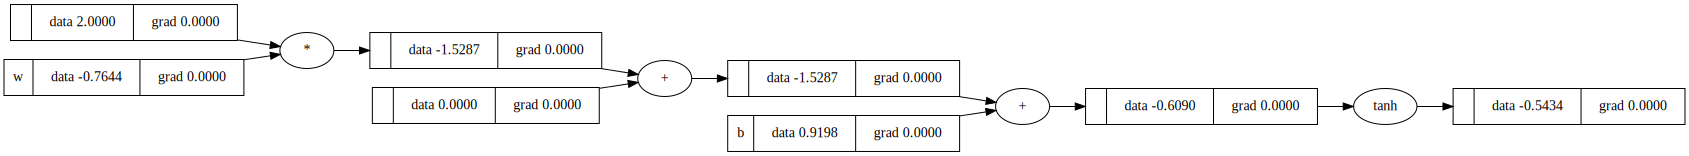

In [15]:
x = [2.0]
n = Neuron(len(x))
out = n(x)
draw_dot(out)

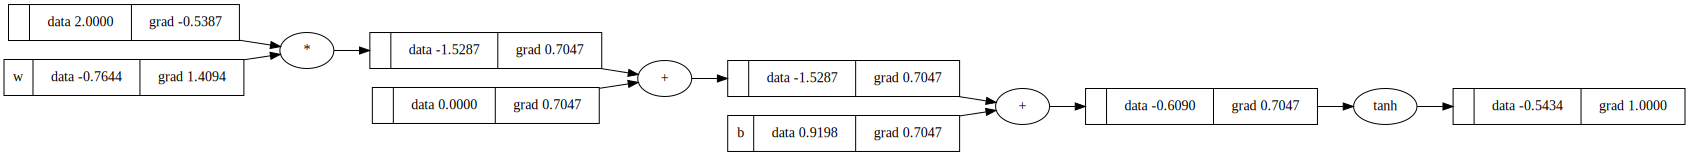

In [16]:
out.backward()
draw_dot(out)

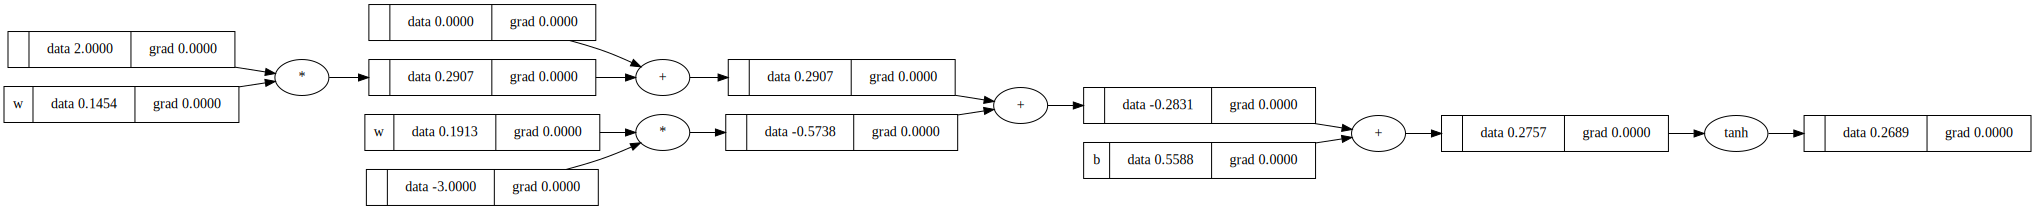

In [17]:
x = [2.0, -3.0]
n = Neuron(len(x))
out = n(x)
draw_dot(out)

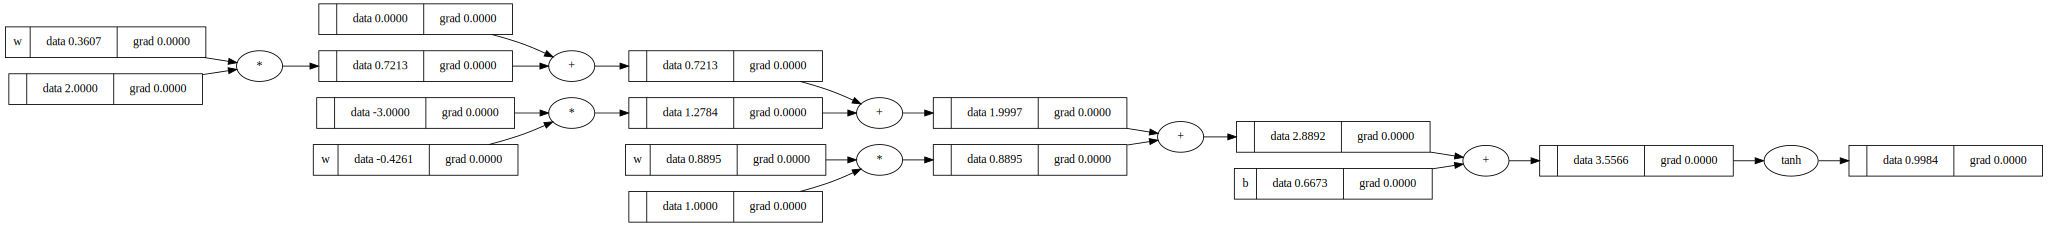

In [18]:
x = [2.0, -3.0, 1.0]
n = Neuron(len(x))
out = n(x)
draw_dot(out)